In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

In [3]:
df.head(),df.shape

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

In [4]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [5]:
emotion_labels = df.iloc[:, 0]

In [15]:
pixels = df.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])

In [7]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

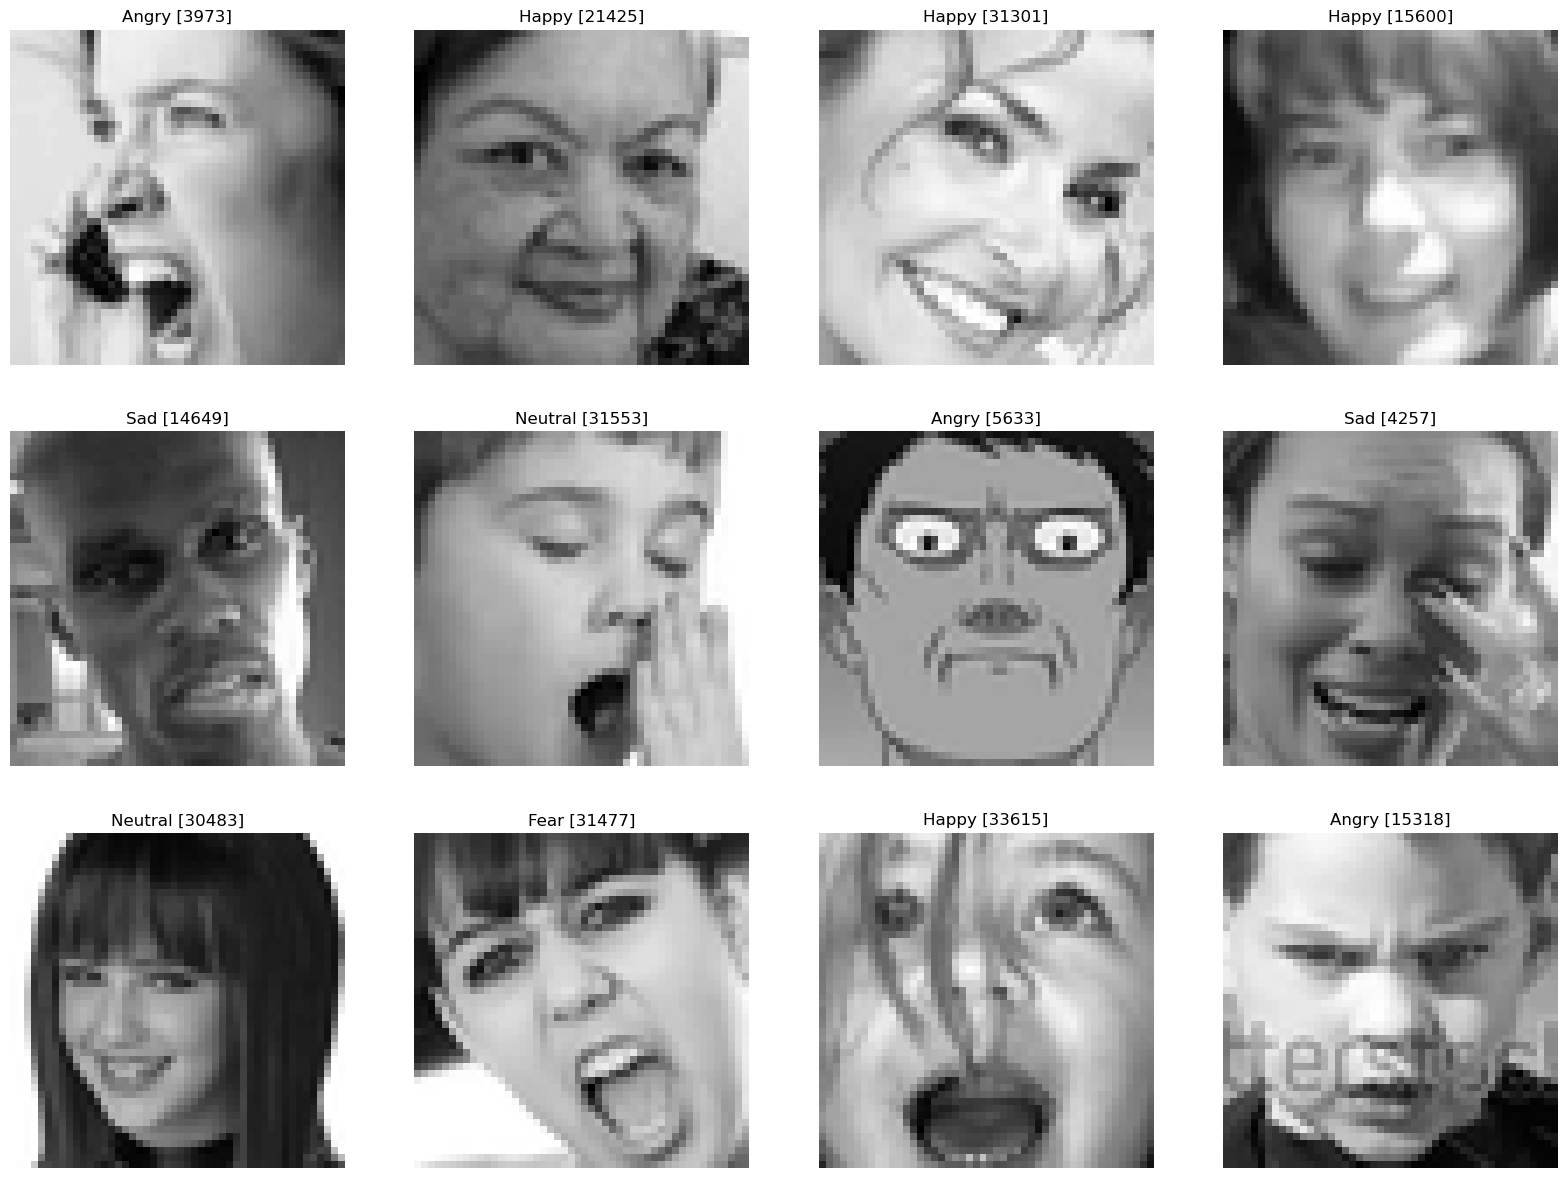

In [8]:
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

In [9]:
train_or_test = df.iloc[:, 2].values
df["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [10]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


In [11]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [16]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1

In [17]:
reshaped_images.shape

(35887, 48, 48, 1)

In [18]:
norm_images = reshaped_images / 255.0

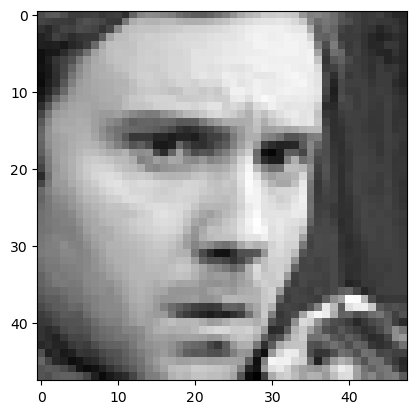

In [19]:
plt.imshow(norm_images[0].reshape((48,48)), cmap="gray")
plt.show()

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
new_labels = to_categorical(emotion_labels, num_classes=7)
new_labels.shape

(35887, 7)

In [22]:
reshaped_images.shape

(35887, 48, 48, 1)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [26]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [27]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))

In [28]:
opt = Adam(lr = 0.0005)

model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

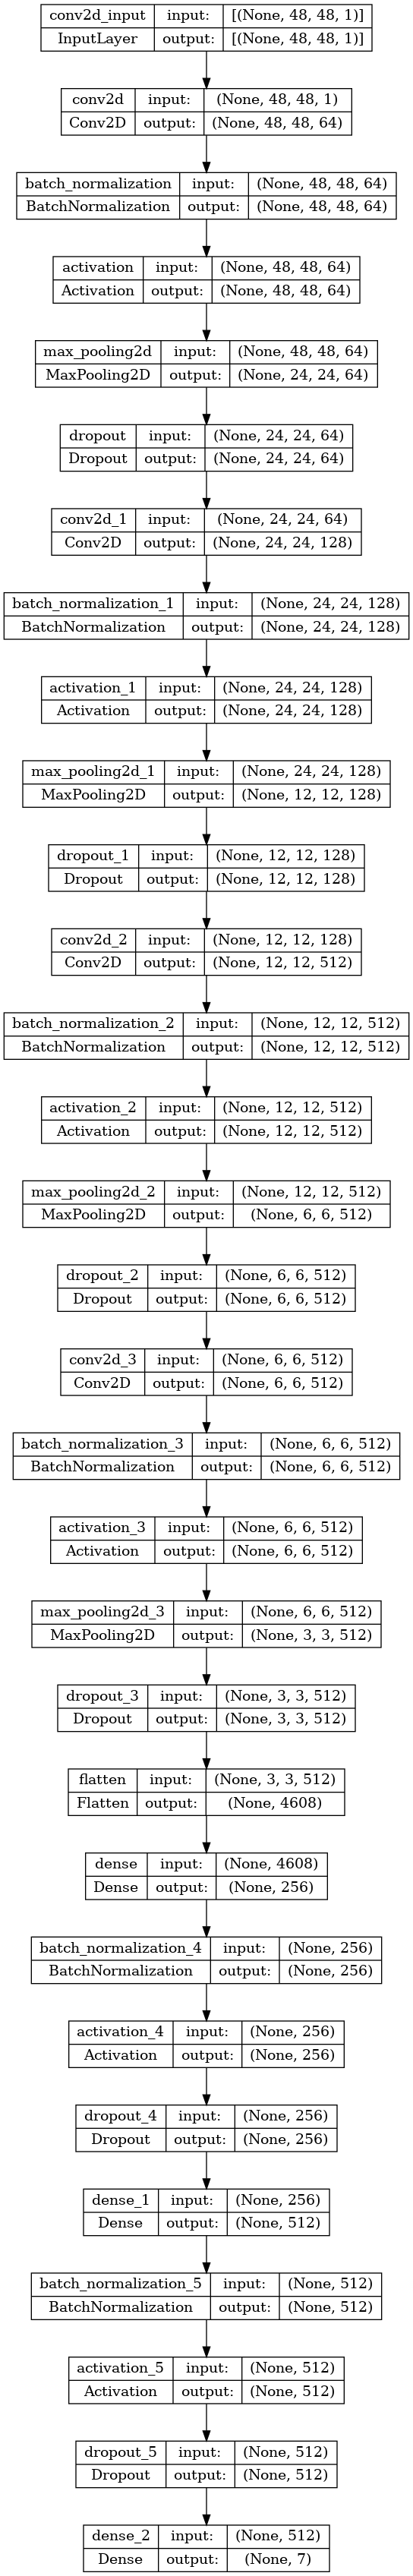

In [30]:
tf.keras.utils.plot_model(model, "final_model.png", show_shapes=True)

In [31]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss', 
                             mode='max', verbose=1)

history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=epochs, 
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/50


2023-03-05 09:42:00.742537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


898/898 [==============================] - ETA: 0s - loss: 1.7057 - accuracy: 0.3432
Epoch 1: saving model to fer_model.h5
898/898 [==============================] - 35s 24ms/step - loss: 1.7057 - accuracy: 0.3432 - val_loss: 1.4971 - val_accuracy: 0.4292 - lr: 0.0010
Epoch 2/50
895/898 [============================>.] - ETA: 0s - loss: 1.3545 - accuracy: 0.4813
Epoch 2: saving model to fer_model.h5
898/898 [==============================] - 19s 21ms/step - loss: 1.3548 - accuracy: 0.4812 - val_loss: 1.3398 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.2389 - accuracy: 0.5271
Epoch 3: saving model to fer_model.h5
898/898 [==============================] - 19s 22ms/step - loss: 1.2389 - accuracy: 0.5271 - val_loss: 1.2329 - val_accuracy: 0.5305 - lr: 0.0010
Epoch 4/50
897/898 [============================>.] - ETA: 0s - loss: 1.1657 - accuracy: 0.5538
Epoch 4: saving model to fer_model.h5
898/898 [============================

In [ ]:
model.save("Final_Model.h5")

In [ ]:
model.save_weights("model_weights.h5")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

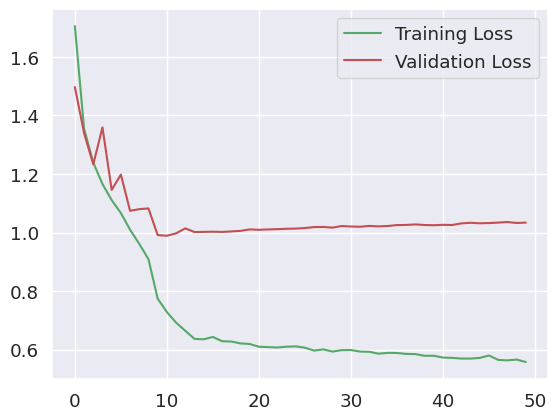

In [59]:
# loss_plot
plt.plot(history.history["loss"],'g', label="Training Loss")
plt.plot(history.history["val_loss"],'r', label="Validation Loss")
plt.legend()

In [36]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

225/225 [==============================] - 1s 5ms/step


In [45]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

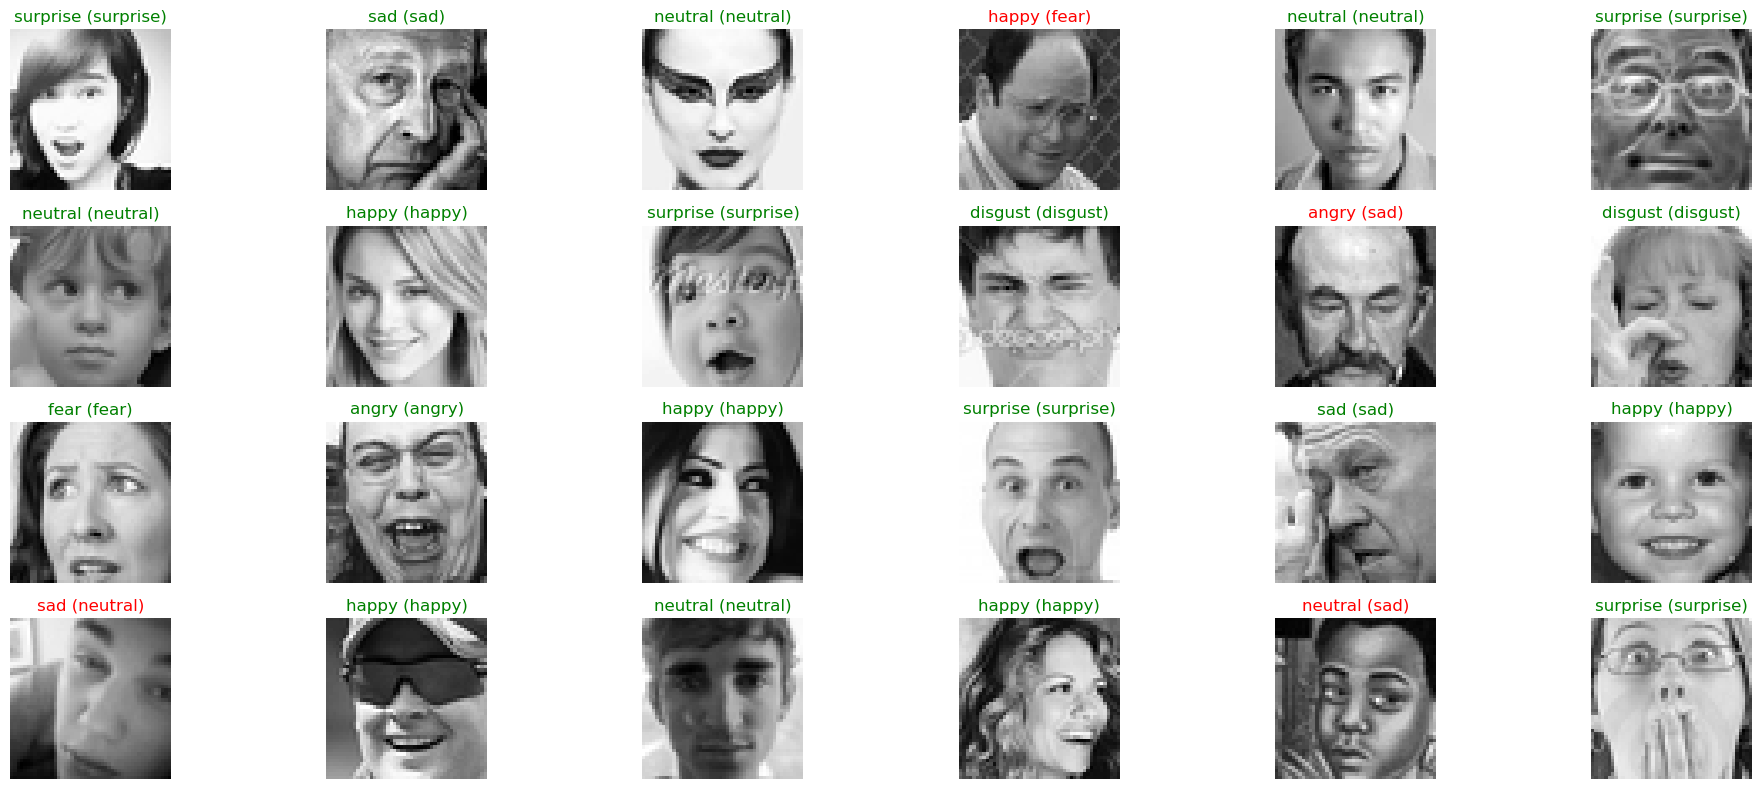

In [44]:
def check_images(X_test, y_pred, label_dict={}):
    fig, axs = plt.subplots(4, 6, figsize=(20, 8))
    axs = axs.flatten()
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
        axs[i].imshow(X_test[idx], cmap='gray')
        pred_idx = label_dict[y_pred[idx]]
        true_idx = label_dict[np.argmax(y_test, axis=1)[idx]]
        title_color = "green" if pred_idx == true_idx else "red"
        axs[i].set_title(f"{pred_idx} ({true_idx})", color=title_color)
        axs[i].axis("off")
    plt.tight_layout()

check_images(X_test, y_pred, emotions)


In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [66]:
# function to plot confusion matrix
def conf_matrix(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Reds", annot=True, annot_kws={"size": 16}, fmt='g')


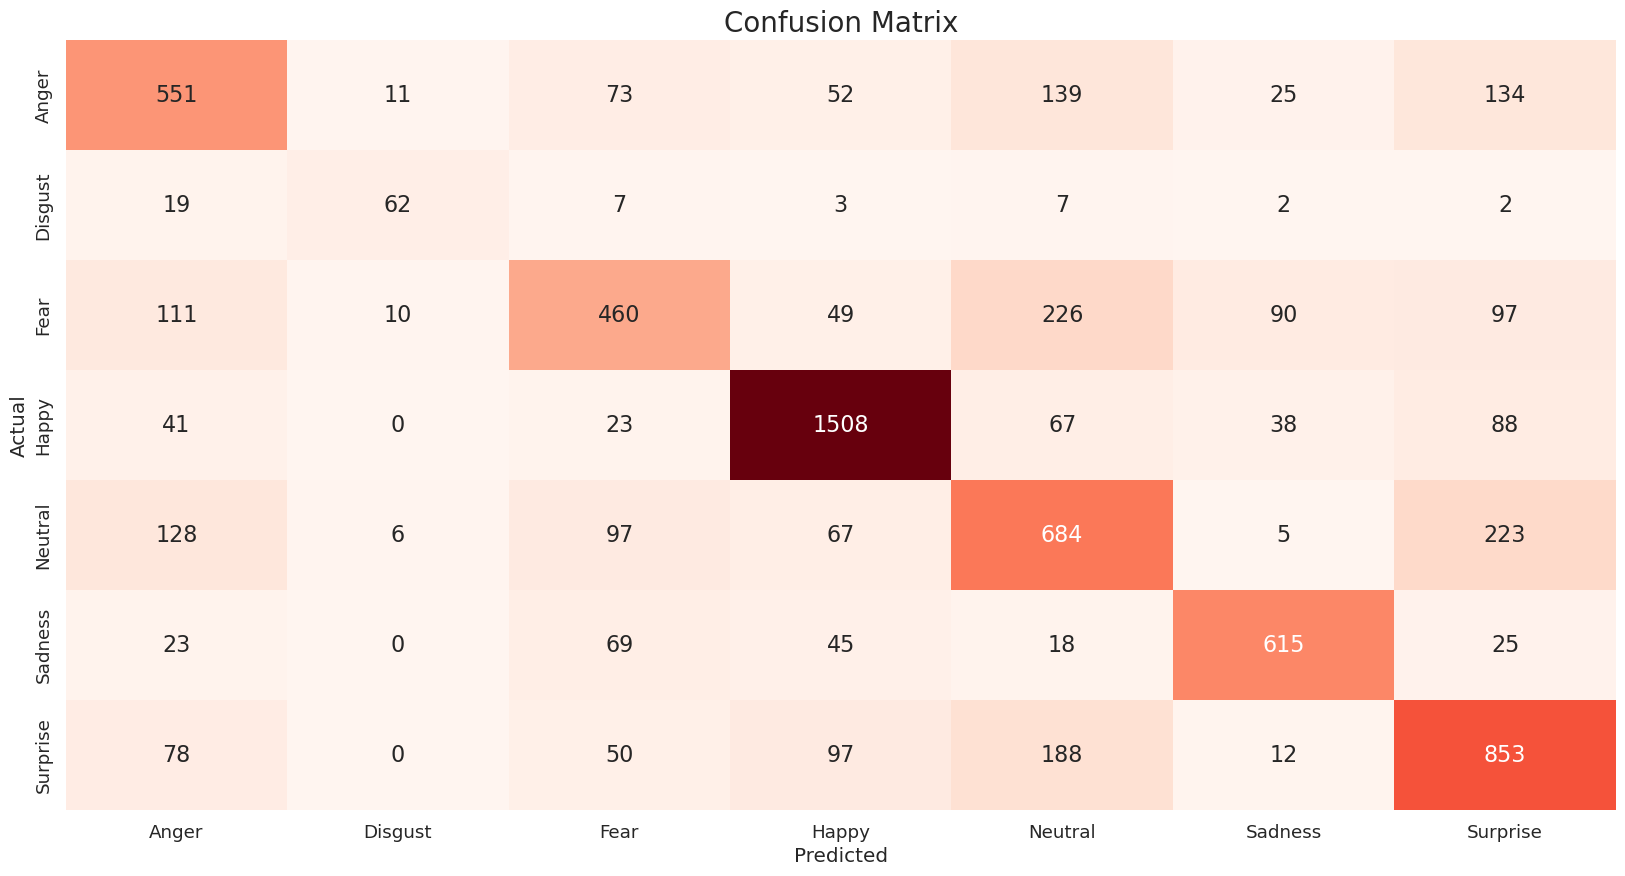

In [67]:
conf_matrix(y_test,y_pred)

In [54]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.579     0.559     0.569       985
           1      0.697     0.608     0.649       102
           2      0.591     0.441     0.505      1043
           3      0.828     0.854     0.841      1765
           4      0.515     0.565     0.539      1210
           5      0.781     0.774     0.777       795
           6      0.600     0.667     0.632      1278

    accuracy                          0.659      7178
   macro avg      0.656     0.638     0.645      7178
weighted avg      0.659     0.659     0.657      7178



In [55]:
 # loss and accuracy
train_loss_and_accuracy = model.evaluate(X_train,y_train)
print("On Training Data",train_loss_and_accuracy)

test_loss_and_accuracy = model.evaluate(X_test,y_test)
print("On Test Data",test_loss_and_accuracy)

898/898 [==============================] - 6s 6ms/step - loss: 0.3152 - accuracy: 0.8983
On Training Data [0.31518498063087463, 0.898254930973053]
225/225 [==============================] - 1s 7ms/step - loss: 1.0338 - accuracy: 0.6594
On Test Data [1.0338335037231445, 0.6593758463859558]


In [60]:
import PIL
from PIL import Image

In [62]:
import cv2

In [80]:
img = cv2.imread("/content/angry-1.jpg")

In [81]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [82]:
img.shape

(259, 194)

In [83]:
img = cv2.resize(img, (48,48))

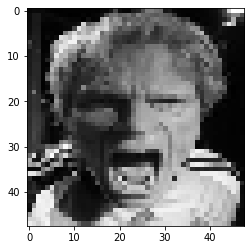

In [84]:
plt.imshow(img, cmap='gray')

In [86]:
np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]

0